# phase 4.2 model evaluation: Word2Vec + LSTM

In [ ]:
import ast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
def visualise_metrics(metrics_summary: pd.DataFrame) -> None:
    plt.figure(figsize=(5, 2)) 
    plt.axis('off')

    table = plt.table(
        cellText=metrics_summary.values,
        colLabels=metrics_summary.columns,
        cellLoc='center',
        loc='center'
    )

    table.scale(1, 1.5) 
    plt.title("Evaluation Metrics", pad=10)
    plt.tight_layout()
    plt.show()

## 5-star classification

In [3]:
def visualise_conf_matrix_5_stars(conf_matrix_df: pd.DataFrame) -> None:
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix_df, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    num_classes = conf_matrix_df.shape[0]
    tick_marks = range(num_classes)

    plt.xticks(tick_marks, range(1, num_classes+1))
    plt.yticks(tick_marks, range(1, num_classes+1))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Add numbers to the boxes
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, format(conf_matrix_df[i, j], 'd'),
                    ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [4]:
def evaluate_model_5_stars(
        test_texts_path: str,
        test_labels_path: str,
        model_path: str,
        label_encoder_path: str
    ) -> tuple:
    # load model
    model = load_model(model_path)

    # load label encoder
    with open(label_encoder_path, 'rb') as file:
        label_encoder = pickle.load(file)

    # load test data
    X_test_raw = pd.read_csv(test_texts_path, index_col=0)
    y_test = pd.read_csv(test_labels_path, index_col=0).squeeze()

    # align indexes
    X_test_raw, y_test = X_test_raw.align(y_test, join='inner', axis=0)

    # parse and pad testing W2V vectors
    X_test_list = X_test_raw['text'].apply(ast.literal_eval).apply(np.array).tolist()
    X_test_padded = pad_sequences(X_test_list, padding='post', dtype='float32')

    # make a prediction
    y_pred_proba = model.predict(X_test_padded)
    y_pred = y_pred_proba.argmax(axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # calculate and save the metrics
    accuracy = accuracy_score(y_test, y_pred_labels)
    precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_labels, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)

    metrics_summary = pd.DataFrame({
        'metric': ['accuracy', 'precision', 'recall', 'f1_score'],
        'value': [accuracy, precision, recall, f1]
    })

    return metrics_summary, conf_matrix

938/938 ━━━━━━━━━━━━━━━━━━━━ 128s 135ms/step


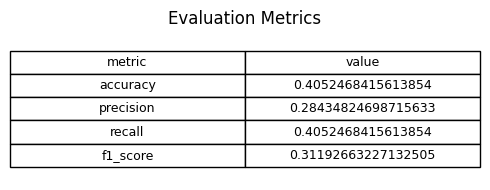

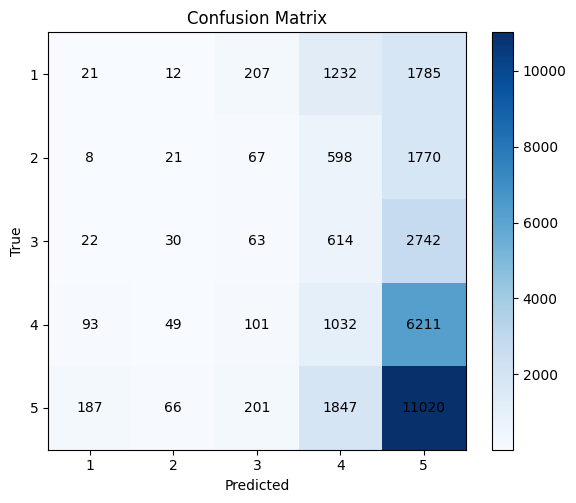

In [8]:
# 70/30 version

metrics, conf_matrix = evaluate_model_5_stars(
    test_texts_path='../data/70_30/test_texts_w2v.csv',
    test_labels_path='../data/70_30/test_labels.csv',
    model_path='../models/w2v_LSTM_70_30.h5',
    label_encoder_path='../models/w2v_LSTM_label_encoder.pkl'
)

visualise_metrics(metrics)
visualise_conf_matrix_5_stars(conf_matrix)

625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step


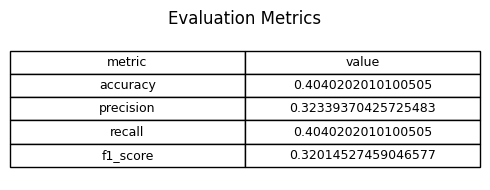

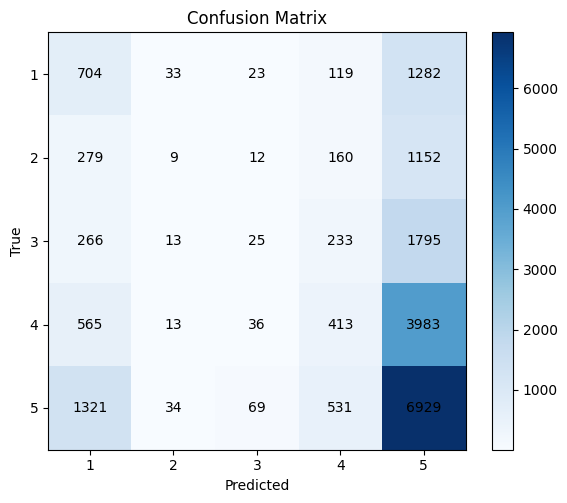

In [9]:
# 80/20 version

metrics, conf_matrix = evaluate_model_5_stars(
    test_texts_path='../data/80_20/test_texts_w2v.csv',
    test_labels_path='../data/80_20/test_labels.csv',
    model_path='../models/w2v_LSTM_80_20.h5',
    label_encoder_path='../models/w2v_LSTM_label_encoder.pkl'
)

visualise_metrics(metrics)
visualise_conf_matrix_5_stars(conf_matrix)

## positive/neutral/negative classification

In [5]:
def visualise_conf_matrix_pnn(conf_matrix) -> None:
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    class_labels = ['Positive', 'Neutral', 'Negative']

    num_classes = conf_matrix.shape[0]
    tick_marks = np.arange(num_classes)

    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()


In [6]:
def evaluate_model_pnn(
        test_texts_path: str,
        test_labels_path: str,
        model_path: str,
        label_encoder_path: str
    ) -> tuple:
    # load model
    model = load_model(model_path)

    # load label encoder
    with open(label_encoder_path, 'rb') as file:
        label_encoder = pickle.load(file)

    # load test data
    X_test_raw = pd.read_csv(test_texts_path, index_col=0)
    y_test = pd.read_csv(test_labels_path, index_col=0).squeeze()

    # map stars to sentiments
    def map_sentiment(star_rating):
        if star_rating in [4, 5]:
            return 'Positive'
        elif star_rating == 3:
            return 'Neutral'                         
        else:
            return 'Negative'

    y_test = y_test.map(map_sentiment)

    # align indexes
    X_test_raw, y_test = X_test_raw.align(y_test, join='inner', axis=0)

    # parse and pad testing W2V vectors
    X_test_list = X_test_raw['text'].apply(ast.literal_eval).apply(np.array).tolist()
    X_test_padded = pad_sequences(X_test_list, padding='post', dtype='float32')

    # make a prediction
    y_pred_proba = model.predict(X_test_padded)
    y_pred = y_pred_proba.argmax(axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # calculate and save the metrics
    accuracy = accuracy_score(y_test, y_pred_labels)
    precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_labels, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)

    metrics_summary = pd.DataFrame({
        'metric': ['accuracy', 'precision', 'recall', 'f1_score'],
        'value': [accuracy, precision, recall, f1]
    })

    return metrics_summary, conf_matrix

938/938 ━━━━━━━━━━━━━━━━━━━━ 125s 132ms/step


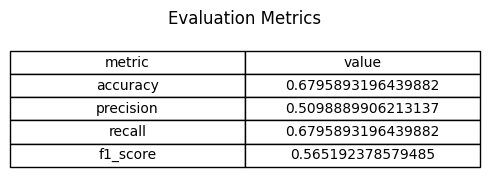

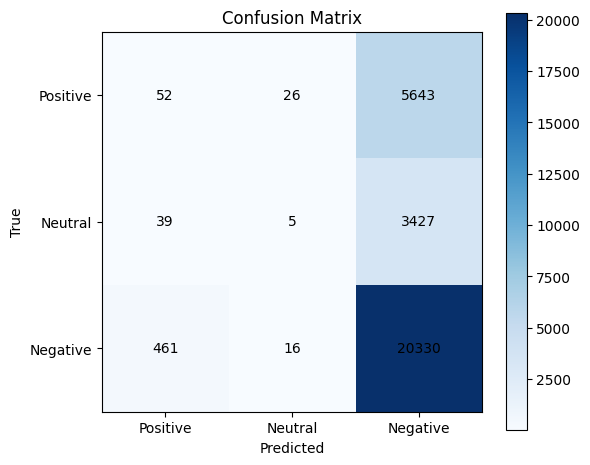

In [7]:
# 70/30 version

metrics, conf_matrix = evaluate_model_pnn(
    test_texts_path='../data/70_30/test_texts_w2v.csv',
    test_labels_path='../data/70_30/test_labels.csv',
    model_path='../models/w2v_LSTM_70_30_PNN.h5',
    label_encoder_path='../models/w2v_LSTM_label_encoder_PNN.pkl'
)

visualise_metrics(metrics)
visualise_conf_matrix_pnn(conf_matrix)

625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step


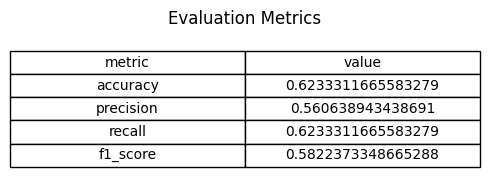

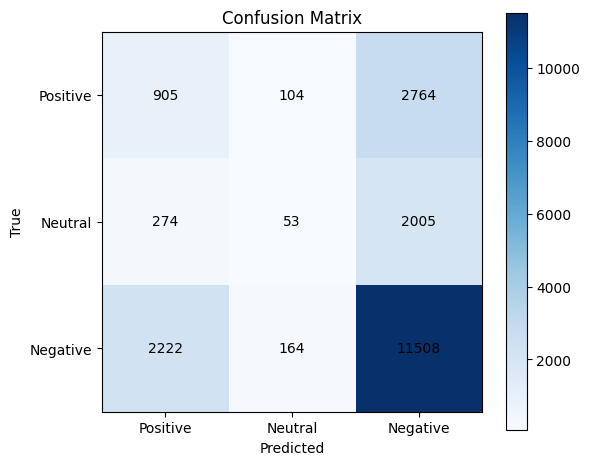

In [10]:
# 80/20 version

metrics, conf_matrix = evaluate_model_pnn(
    test_texts_path='../data/80_20/test_texts_w2v.csv',
    test_labels_path='../data/80_20/test_labels.csv',
    model_path='../models/w2v_LSTM_80_20_PNN.h5',
    label_encoder_path='../models/w2v_LSTM_label_encoder_PNN.pkl'
)

visualise_metrics(metrics)
visualise_conf_matrix_pnn(conf_matrix)

## conclusions

Summary of models metrics:

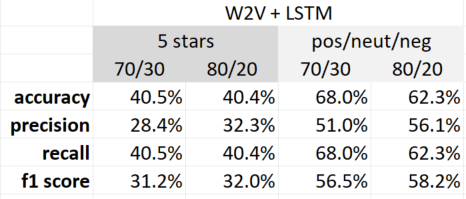

Conclusions:

- classification into positive/neutral/negative achieves better results
- there isn't a big difference in performance between models trained in the 70/30 vs 80/20 proportions
- overall metrics are much better than BoW + NB

Why is there an improvement?

- Word2Vec captures relationships between words, which can be significant in natural language reviews, especially in negations
- LSTM is a much more complex and nuanced model than Naive Bayes